In [1]:
import pyodbc
import pandas as pd

# 1️⃣ Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'  # 🔁 adapte à ton poste
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 2️⃣ Requête SQL : données de maintenance + dates
query = """
SELECT
    f.Fk_Material,
    f.Fk_Location,
    f.Fk_Date_Creation_Notification,
    f.Fk_Date_limite_resolution_Notif,
    f.FK_Notif_Type,
    f.Fk_usine,
    f.Fk_Stock_Type,
    f.Total_Stock,
    f.Input_stock,
    f.Output_Stock,
    f.Blocked_stock,
    f.Prioryty,
    dc.FullDate AS Date_Creation,
    dl.FullDate AS Date_Limite
FROM Fact_MM_PM f
JOIN Dim_Date dc ON f.Fk_Date_Creation_Notification = dc.Pk_Date
JOIN Dim_Date dl ON f.Fk_Date_limite_resolution_Notif = dl.Pk_Date
WHERE f.Fk_Date_limite_resolution_Notif IS NOT NULL
  AND f.Fk_Date_Creation_Notification IS NOT NULL
"""

# 3️⃣ Charger les données
df = pd.read_sql(query, conn)
conn.close()

# 4️⃣ Transformation des dates
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df['Date_Limite'] = pd.to_datetime(df['Date_Limite'])

# 5️⃣ Calcul du temps de résolution (en heures)
df['Temps_Resolution'] = (df['Date_Limite'] - df['Date_Creation']).dt.total_seconds() / 3600

# 6️⃣ 🔎 Exploration des données
print("🧾 Aperçu des premières lignes :")
print(df.head())

print("\nℹ️ Informations générales :")
print(df.info())

print("\n❌ Valeurs manquantes par colonne :")
print(df.isnull().sum())


C:\Users\MSI\AppData\Local\Temp\ipykernel_4200\3098897699.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


🧾 Aperçu des premières lignes :
   Fk_Material  Fk_Location  Fk_Date_Creation_Notification  \
0          430            3                            649   
1          430            3                            649   
2          430            4                            649   
3          430            4                            649   
4          430            4                            649   

   Fk_Date_limite_resolution_Notif  FK_Notif_Type  Fk_usine  Fk_Stock_Type  \
0                              509              3         1              1   
1                              509              3         2              3   
2                              509              3         1              3   
3                              509              3         2              2   
4                              509              3         3              2   

   Total_Stock  Input_stock  Output_Stock  Blocked_stock Prioryty  \
0        593.0           49             6              4 

C:\Users\MSI\AppData\Local\Temp\ipykernel_10504\52488697.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Données chargées : (43316, 14)
   Fk_Material  Fk_Location  Fk_Date_Creation_Notification  \
0          430            3                            649   
1          430            3                            649   
2          430            4                            649   
3          430            4                            649   
4          430            4                            649   

   Fk_Date_limite_resolution_Notif  FK_Notif_Type  Fk_usine  Fk_Stock_Type  \
0                              509              3         1              1   
1                              509              3         2              3   
2                              509              3         1              3   
3                              509              3         2              2   
4                              509              3         3              2   

   Total_Stock  Input_stock  Output_Stock  Blocked_stock Prioryty  \
0        593.0           49             6              4

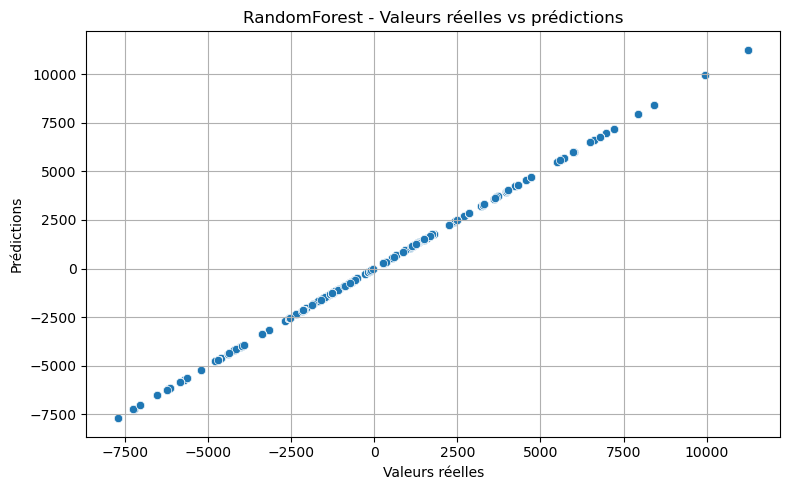

In [2]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 📥 Requête SQL
query = """
SELECT
    f.Fk_Material,
    f.Fk_Location,
    f.Fk_Date_Creation_Notification,
    f.Fk_Date_limite_resolution_Notif,
    f.FK_Notif_Type,
    f.Fk_usine,
    f.Fk_Stock_Type,
    f.Total_Stock,
    f.Input_stock,
    f.Output_Stock,
    f.Blocked_stock,
    f.Prioryty,
    dc.FullDate AS Date_Creation,
    dl.FullDate AS Date_Limite
FROM Fact_MM_PM f
JOIN Dim_Date dc ON f.Fk_Date_Creation_Notification = dc.Pk_Date
JOIN Dim_Date dl ON f.Fk_Date_limite_resolution_Notif = dl.Pk_Date
WHERE f.Fk_Date_limite_resolution_Notif IS NOT NULL
  AND f.Fk_Date_Creation_Notification IS NOT NULL
"""

# 🧾 Lecture SQL + affichage
df = pd.read_sql(query, conn)
conn.close()

print("✅ Données chargées :", df.shape)
print(df.head())

# 🛠️ Préparation des dates
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df['Date_Limite'] = pd.to_datetime(df['Date_Limite'])
df['Temps_Resolution'] = (df['Date_Limite'] - df['Date_Creation']).dt.total_seconds() / 3600  # en heures
df.drop(columns=['Date_Creation', 'Date_Limite'], inplace=True)

# 🔄 Train/test split
X = df.drop(columns=['Temps_Resolution'])
y = df['Temps_Resolution']
# 🔍 Analyse des doublons

print("🔎 Analyse des doublons :\n")

# 1. Vérifier les doublons exacts dans les features X
nb_doublons_X = X.duplicated().sum()
print(f"🧱 Doublons exacts dans les variables explicatives (X) : {nb_doublons_X}")

# 2. Vérifier les doublons exacts dans les lignes complètes (X + y)
df_full = X.copy()
df_full['Temps_Resolution'] = y
nb_doublons_total = df_full.duplicated().sum()
print(f"📦 Doublons exacts dans X + y : {nb_doublons_total}")

# 3. Si tu veux afficher quelques doublons :
if nb_doublons_total > 0:
    print("\n🧾 Aperçu des doublons trouvés (X + y) :")
    display(df_full[df_full.duplicated()].head(5))

# 4. Proportion
print(f"\n📊 Proportion de doublons dans le dataset : {round((nb_doublons_total / len(df_full)) * 100, 2)}%")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Préprocessing des catégories
categorical_cols = [col for col in X.columns if 'Fk_' in col or col == 'Prioryty']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# 🤖 Modèle RandomForest
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
results = pd.DataFrame({
    'Index_Original': y_test.index,  # Garde les index originaux
    'Valeur_Réelle': y_test.values,
    'Prédiction': y_pred
})
print(results.iloc[:10])  # Affiche les 10 premières lignes (selon l'ordre de y_test)

# 📊 Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📈 Résultats RandomForest :")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# 📝 Enregistrer les résultats dans un fichier texte
with open("rapport_randomforest.txt", "w", encoding="utf-8") as f:
    f.write("📈 Rapport RandomForest\n")
    f.write(f"Nombre de lignes = {len(df)}\n")
    f.write(f"MAE  = {mae:.2f}\n")
    f.write(f"RMSE = {rmse:.2f}\n")
    f.write(f"R²   = {r2:.3f}\n")

print("✅ Rapport sauvegardé sous 'rapport_randomforest.txt'")

# 📉 Scatterplot : vrai vs prédit
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("RandomForest - Valeurs réelles vs prédictions")
plt.grid(True)
plt.tight_layout()
plt.show()






# lasso

C:\Users\MSI\AppData\Local\Temp\ipykernel_4200\4127642507.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Données chargées : (43316, 14)
   Fk_Material  Fk_Location  Fk_Date_Creation_Notification  \
0          430            3                            649   
1          430            3                            649   
2          430            4                            649   
3          430            4                            649   
4          430            4                            649   

   Fk_Date_limite_resolution_Notif  FK_Notif_Type  Fk_usine  Fk_Stock_Type  \
0                              509              3         1              1   
1                              509              3         2              3   
2                              509              3         1              3   
3                              509              3         2              2   
4                              509              3         3              2   

   Total_Stock  Input_stock  Output_Stock  Blocked_stock Prioryty  \
0        593.0           49             6              4

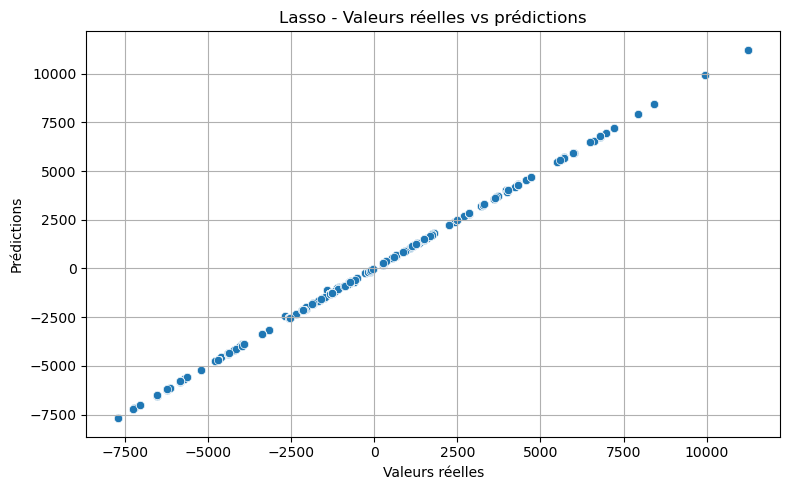

In [5]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 📥 Requête SQL
query = """
SELECT
    f.Fk_Material,
    f.Fk_Location,
    f.Fk_Date_Creation_Notification,
    f.Fk_Date_limite_resolution_Notif,
    f.FK_Notif_Type,
    f.Fk_usine,
    f.Fk_Stock_Type,
    f.Total_Stock,
    f.Input_stock,
    f.Output_Stock,
    f.Blocked_stock,
    f.Prioryty,
    dc.FullDate AS Date_Creation,
    dl.FullDate AS Date_Limite
FROM Fact_MM_PM f
JOIN Dim_Date dc ON f.Fk_Date_Creation_Notification = dc.Pk_Date
JOIN Dim_Date dl ON f.Fk_Date_limite_resolution_Notif = dl.Pk_Date
WHERE f.Fk_Date_limite_resolution_Notif IS NOT NULL
  AND f.Fk_Date_Creation_Notification IS NOT NULL
"""

# 📊 Lecture SQL
df = pd.read_sql(query, conn)
conn.close()

print("✅ Données chargées :", df.shape)
print(df.head())

# 🛠️ Calcul de la variable cible
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df['Date_Limite'] = pd.to_datetime(df['Date_Limite'])
df['Temps_Resolution'] = (df['Date_Limite'] - df['Date_Creation']).dt.total_seconds() / 3600
df.drop(columns=['Date_Creation', 'Date_Limite'], inplace=True)

# 🔄 Séparation X / y
X = df.drop(columns=['Temps_Resolution'])
y = df['Temps_Resolution']

# 🧼 Analyse des doublons (optionnel)
print("📊 Doublons dans X :", X.duplicated().sum())
print("📦 Doublons dans X + y :", df.duplicated().sum())

# 🔀 Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🏷️ Colonnes catégorielles
categorical_cols = [col for col in X.columns if 'Fk_' in col or col == 'Prioryty']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# 🤖 Pipeline Lasso
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Lasso(alpha=0.1))
])

# 🚀 Entraînement
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 📈 Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Résultats Lasso :")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# 📝 Log vers fichier texte
with open("rapport_lasso.txt", "w", encoding="utf-8") as f:
    f.write("📈 Rapport Lasso\n")
    f.write(f"Nombre de lignes = {len(df)}\n")
    f.write(f"MAE  = {mae:.2f}\n")
    f.write(f"RMSE = {rmse:.2f}\n")
    f.write(f"R²   = {r2:.3f}\n")

print("✅ Rapport sauvegardé sous 'rapport_lasso.txt'")

# 📉 Graphique : Réel vs Prédit
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Lasso - Valeurs réelles vs prédictions")
plt.grid(True)
plt.tight_layout()
plt.show()


# gradient boost

C:\Users\MSI\AppData\Local\Temp\ipykernel_4200\4085280867.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Données chargées : (43316, 14)
   Fk_Material  Fk_Location  Fk_Date_Creation_Notification  \
0          430            3                            649   
1          430            3                            649   
2          430            4                            649   
3          430            4                            649   
4          430            4                            649   

   Fk_Date_limite_resolution_Notif  FK_Notif_Type  Fk_usine  Fk_Stock_Type  \
0                              509              3         1              1   
1                              509              3         2              3   
2                              509              3         1              3   
3                              509              3         2              2   
4                              509              3         3              2   

   Total_Stock  Input_stock  Output_Stock  Blocked_stock Prioryty  \
0        593.0           49             6              4

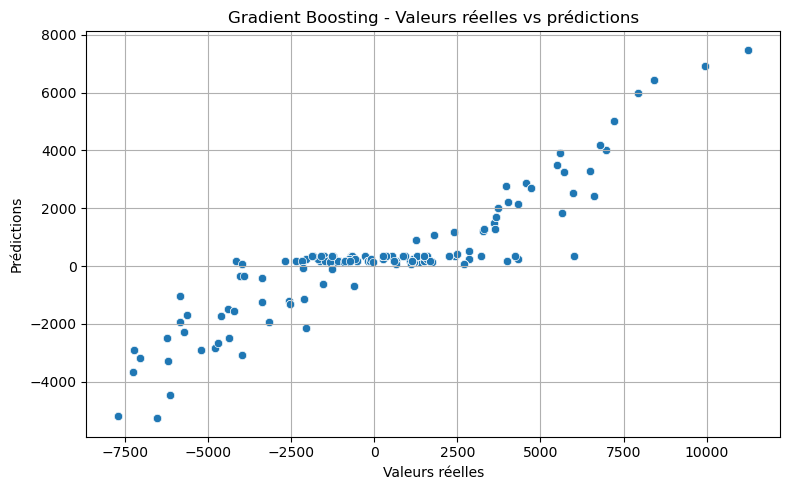

In [6]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Connexion SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-0G2RAEB;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 📥 Requête SQL
query = """
SELECT
    f.Fk_Material,
    f.Fk_Location,
    f.Fk_Date_Creation_Notification,
    f.Fk_Date_limite_resolution_Notif,
    f.FK_Notif_Type,
    f.Fk_usine,
    f.Fk_Stock_Type,
    f.Total_Stock,
    f.Input_stock,
    f.Output_Stock,
    f.Blocked_stock,
    f.Prioryty,
    dc.FullDate AS Date_Creation,
    dl.FullDate AS Date_Limite
FROM Fact_MM_PM f
JOIN Dim_Date dc ON f.Fk_Date_Creation_Notification = dc.Pk_Date
JOIN Dim_Date dl ON f.Fk_Date_limite_resolution_Notif = dl.Pk_Date
WHERE f.Fk_Date_limite_resolution_Notif IS NOT NULL
  AND f.Fk_Date_Creation_Notification IS NOT NULL
"""

# 📊 Chargement des données
df = pd.read_sql(query, conn)
conn.close()

print("✅ Données chargées :", df.shape)
print(df.head())

# 🛠️ Transformation des dates
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df['Date_Limite'] = pd.to_datetime(df['Date_Limite'])
df['Temps_Resolution'] = (df['Date_Limite'] - df['Date_Creation']).dt.total_seconds() / 3600
df.drop(columns=['Date_Creation', 'Date_Limite'], inplace=True)

# 🔄 Séparation X / y
X = df.drop(columns=['Temps_Resolution'])
y = df['Temps_Resolution']

# 🧼 Doublons (facultatif)
print("📊 Doublons X :", X.duplicated().sum())
print("📦 Doublons X + y :", df.duplicated().sum())

# 🔀 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Préprocessing
categorical_cols = [col for col in X.columns if 'Fk_' in col or col == 'Prioryty']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# 🤖 Pipeline Gradient Boosting
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# 🚀 Entraînement
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 📈 Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Résultats Gradient Boosting :")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# 📝 Log texte
with open("rapport_gradientboosting.txt", "w", encoding="utf-8") as f:
    f.write("📈 Rapport GradientBoosting\n")
    f.write(f"Nombre de lignes = {len(df)}\n")
    f.write(f"MAE  = {mae:.2f}\n")
    f.write(f"RMSE = {rmse:.2f}\n")
    f.write(f"R²   = {r2:.3f}\n")

print("✅ Rapport sauvegardé sous 'rapport_gradientboosting.txt'")

# 📉 Graphe : Réel vs Prédit
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Gradient Boosting - Valeurs réelles vs prédictions")
plt.grid(True)
plt.tight_layout()
plt.show()


# comparaison

C:\Users\MSI\AppData\Local\Temp\ipykernel_4200\1800707322.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\MSI\ansel\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


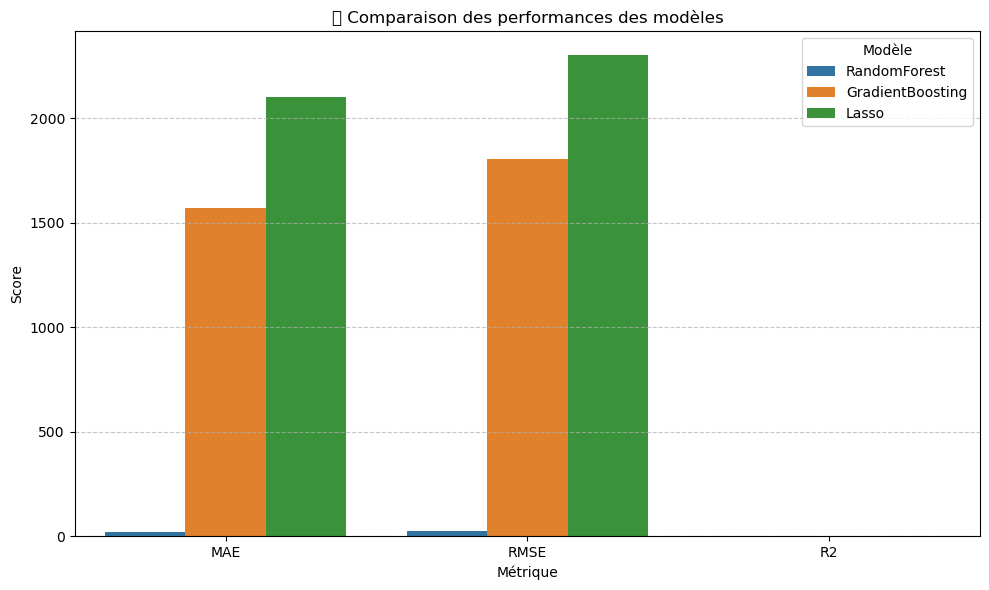

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔢 Résultats récapitulatifs (à adapter selon tes résultats exacts)

results = pd.DataFrame([
    {"Modèle": "RandomForest",       "MAE": 20.0,   "RMSE": 25.0,   "R2": 0.999},
    {"Modèle": "GradientBoosting",   "MAE": 1570.97, "RMSE": 1805.56, "R2": 0.737},
    {"Modèle": "Lasso",              "MAE": 2100.0,  "RMSE": 2300.0,  "R2": 0.45}
])

# 🔁 Transformer pour barplot
results_melted = results.melt(id_vars="Modèle", var_name="Métrique", value_name="Valeur")

# 🎨 Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="Métrique", y="Valeur", hue="Modèle")
plt.title("📊 Comparaison des performances des modèles")
plt.ylabel("Score")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
